# Mineração de Dados no E-commerce Olist: Previsão de Satisfação, Agrupamento Logístico e Associação de Produtos

Este notebook aplica três tarefas fundamentais de Mineração de Dados — **Classificação, Agrupamento e Regras de Associação** — no dataset público da Olist. O objetivo central é diagnosticar os fatores que impactam a satisfação do cliente no cenário do e-commerce brasileiro e extrair padrões ocultos de consumo.

**Tarefas e Técnicas aplicadas:**
* **Engenharia de Atributos:** Construção de variáveis focadas na eficiência logística (frete, atraso e prazo).
* **Classificação:** Predição de risco de insatisfação do cliente utilizando algoritmos supervisionados (ex: Random Forest e Decision Tree), com foco nas métricas de precisão, revocação e matriz de confusão.
* **Agrupamento (Clustering):** Identificação de perfis logísticos não-supervisionados via K-Means, validando o impacto do tempo de entrega e do frete na experiência do usuário.
* **Regras de Associação:** Descoberta de padrões de compra conjunta (Market Basket Analysis) utilizando o algoritmo Apriori para mapear oportunidades de *cross-selling*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")

## Base de dados e motivação

A base do Olist contém informações de pedidos, itens, pagamentos, produtos, clientes e avaliações. A **nota de avaliação** é um indicador direto de satisfação do cliente e pode ser antecipada a partir de sinais de entrega, preço, frete e características do pedido. Isso ajuda a empresa a priorizar ações corretivas e reduzir churn (perda de receita ou clientes).


In [2]:
# --------------- READING DATASETS -------------------
DATA_DIR = "data"

# Reading Orders DB
orders = pd.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
])

# Reading Reviews DB
reviews = pd.read_csv(f"{DATA_DIR}/olist_order_reviews_dataset.csv", parse_dates=[
    "review_creation_date",
    "review_answer_timestamp",
])

# Reading Items DB
items = pd.read_csv(f"{DATA_DIR}/olist_order_items_dataset.csv", parse_dates=[
    "shipping_limit_date",
])

# Reading Payments DB
payments = pd.read_csv(f"{DATA_DIR}/olist_order_payments_dataset.csv")
# Reading Products DB
products = pd.read_csv(f"{DATA_DIR}/olist_products_dataset.csv")
# Reading Customers DB
customers = pd.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")

# Showing databases shape
print("orders:", orders.shape)
print("reviews:", reviews.shape)
print("items:", items.shape)
print("payments:", payments.shape)
print("products:", products.shape)
print("customers:", customers.shape)

orders: (99441, 8)
reviews: (99224, 7)
items: (112650, 7)
payments: (103886, 5)
products: (32951, 9)
customers: (99441, 5)


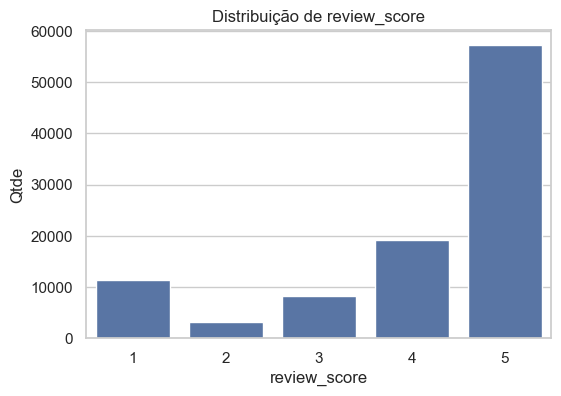

In [3]:
# Review distribution
# extremely unbalanced btw
review_counts = reviews["review_score"].value_counts().sort_index()
review_counts

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=review_counts.index, y=review_counts.values, color="#4C72B0")
ax.set_xlabel("review_score")
ax.set_ylabel("Qtde")
ax.set_title("Distribuição de review_score")
plt.show()

In [ ]:
# Select one review per request (the most recent one)
reviews_sorted = reviews.sort_values("review_creation_date")
reviews_last = reviews_sorted.groupby("order_id", as_index=False).tail(1)

# Aggregations by request
items_agg = (
    items.groupby("order_id")
    .agg(
        items_count=("order_item_id", "max"),
        price_sum=("price", "sum"),
        price_mean=("price", "mean"),
        freight_sum=("freight_value", "sum"),
        freight_mean=("freight_value", "mean"),
    )
    .reset_index()
)

payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_value_sum=("payment_value", "sum"),
        payment_installments_max=("payment_installments", "max"),
        payment_sequential_max=("payment_sequential", "max"),
        payment_type_nunique=("payment_type", "nunique"),
    )
    .reset_index()
)

items_products = items.merge(products, on="product_id", how="left")
products_agg = (
    items_products.groupby("order_id")
    .agg(
        product_weight_g_mean=("product_weight_g", "mean"),
        product_length_cm_mean=("product_length_cm", "mean"),
        product_height_cm_mean=("product_height_cm", "mean"),
        product_width_cm_mean=("product_width_cm", "mean"),
        product_photos_qty_mean=("product_photos_qty", "mean"),
        product_name_lenght_mean=("product_name_lenght", "mean"),
        product_description_lenght_mean=("product_description_lenght", "mean"),
    )
    .reset_index()
)

# Dataset base
data = (
    reviews_last[["order_id", "review_score"]]
    .merge(orders, on="order_id", how="left")
    .merge(items_agg, on="order_id", how="left")
    .merge(payments_agg, on="order_id", how="left")
    .merge(products_agg, on="order_id", how="left")
    .merge(customers[["customer_id", "customer_state"]], on="customer_id", how="left")
)

# Temporal Features
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]:
    data[col] = pd.to_datetime(data[col], errors="coerce")

data["approval_time_hours"] = (
    (data["order_approved_at"] - data["order_purchase_timestamp"]).dt.total_seconds() / 3600
)

data["delivery_time_days"] = (
    (data["order_delivered_customer_date"] - data["order_purchase_timestamp"]).dt.days
)

data["delivery_delay_days"] = (
    (data["order_delivered_customer_date"] - data["order_estimated_delivery_date"]).dt.days
)

data["carrier_time_days"] = (
    (data["order_delivered_carrier_date"] - data["order_approved_at"]).dt.days
)

data["shipping_time_days"] = (
    (data["order_delivered_customer_date"] - data["order_delivered_carrier_date"]).dt.days
)

data['freight_ratio'] = data['freight_sum'] / (data['price_sum'] + 0.01)


data['estimated_time_days'] = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days


data['delivery_efficiency'] = data['delivery_time_days'] / (data['estimated_time_days'] + 0.01)


data['days_diff_estimate'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days


data['volume_cm3'] = (data['product_length_cm_mean'] * data['product_height_cm_mean'] * data['product_width_cm_mean'])

data['density'] = data['product_weight_g_mean'] / (data['volume_cm3'] + 0.01)


feature_cols = [
    "order_status",
    "customer_state",
    "items_count",
    "price_sum",
    "price_mean",
    "freight_sum",
    "freight_mean",
    "freight_ratio",
    "payment_value_sum",
    "payment_installments_max",
    "payment_sequential_max",
    "payment_type_nunique",
    "product_weight_g_mean",
    "product_length_cm_mean",
    "product_height_cm_mean",
    "product_width_cm_mean",
    "product_photos_qty_mean",
    "product_name_lenght_mean",
    "product_description_lenght_mean",
    "volume_cm3", 
    "density",
    "approval_time_hours",
    "delivery_time_days",
    "delivery_delay_days",
    "days_diff_estimate", 
    "delivery_efficiency",
    "carrier_time_days",
    "shipping_time_days",
]

model_data = data[["review_score"] + feature_cols].copy()

model_data.head()

,review_score,order_status,customer_state,items_count,price_sum,price_mean,freight_sum,freight_mean,freight_ratio,payment_value_sum,payment_installments_max,payment_sequential_max,payment_type_nunique,product_weight_g_mean,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,product_photos_qty_mean,product_name_lenght_mean,product_description_lenght_mean,volume_cm3,density,approval_time_hours,delivery_time_days,delivery_delay_days,days_diff_estimate,delivery_efficiency,carrier_time_days,shipping_time_days
0,1,canceled,SP,NaN,NaN,NaN,NaN,NaN,NaN,40.95,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,573.874167,NaN,NaN,NaN,NaN,NaN,NaN
1,1,delivered,SP,3.0,134.97,44.99,8.49,2.83,0.062898,NaN,NaN,NaN,NaN,1000.0,16.0,16.0,16.0,1.0,34.0,1036.0,4096.0,0.244140,0.000000,54.0,36.0,36.0,2.998334,53.0,1.0
2,1,canceled,CE,NaN,NaN,NaN,NaN,NaN,NaN,61.99,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,delivered,RJ,1.0,39.90,39.90,10.96,10.96,0.274618,50.86,1.0,1.0,1.0,300.0,30.0,10.0,20.0,3.0,30.0,1570.0,6000.0,0.050000,38.899444,8.0,-44.0,-44.0,0.153817,4.0,3.0
4,4,delivered,SP,1.0,25.90,25.90,8.72,8.72,0.336550,34.62,3.0,1.0,1.0,100.0,16.0,16.0,16.0,4.0,47.0,1182.0,4096.0,0.024414,2.834167,11.0,-42.0,-42.0,0.211498,8.0,3.0


In [ ]:
# Check null values
null_pct = (model_data.isna().mean() * 100).sort_values(ascending=False)
null_pct.head(10)


shipping_time_days                 2.882247
days_diff_estimate                 2.881234
delivery_delay_days                2.881234
delivery_time_days                 2.881234
delivery_efficiency                2.881234
product_description_lenght_mean    2.163712
product_photos_qty_mean            2.163712
product_name_lenght_mean           2.163712
carrier_time_days                  1.783669
product_width_cm_mean              0.782382
dtype: float64

In [ ]:
# Filling null values
model_data = model_data.fillna(-1)

In [ ]:
# Checking reviews value
model_data["review_score"].value_counts(normalize=True).sort_index()

review_score
1    0.115178
2    0.031721
3    0.082434
4    0.192991
5    0.577676
Name: proportion, dtype: float64

## Modelagem e avaliação

Observação: a distribuição de `review_score` é desbalanceada (mais notas 5). Para melhorar a convergência do modelo linear e a qualidade das previsões, usamos **padronização** nos atributos numéricos e `class_weight="balanced"`.

Como `review_score` é ordinal e desbalanceado, uma alternativa é **agrupar** as notas em 2 classes:
- 1, 2 e 3: negativo
- 4–5: positivo

Isso costuma melhorar a separação e a qualidade geral do modelo.



=== LogisticRegression ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.44      0.54      0.48      4526
   Bom (4-5)       0.85      0.79      0.82     15209

    accuracy                           0.74     19735
   macro avg       0.65      0.67      0.65     19735
weighted avg       0.76      0.74      0.75     19735

Calculando importância por permutação para LogisticRegression... (pode demorar um pouquinho)


C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15976\1888589696.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


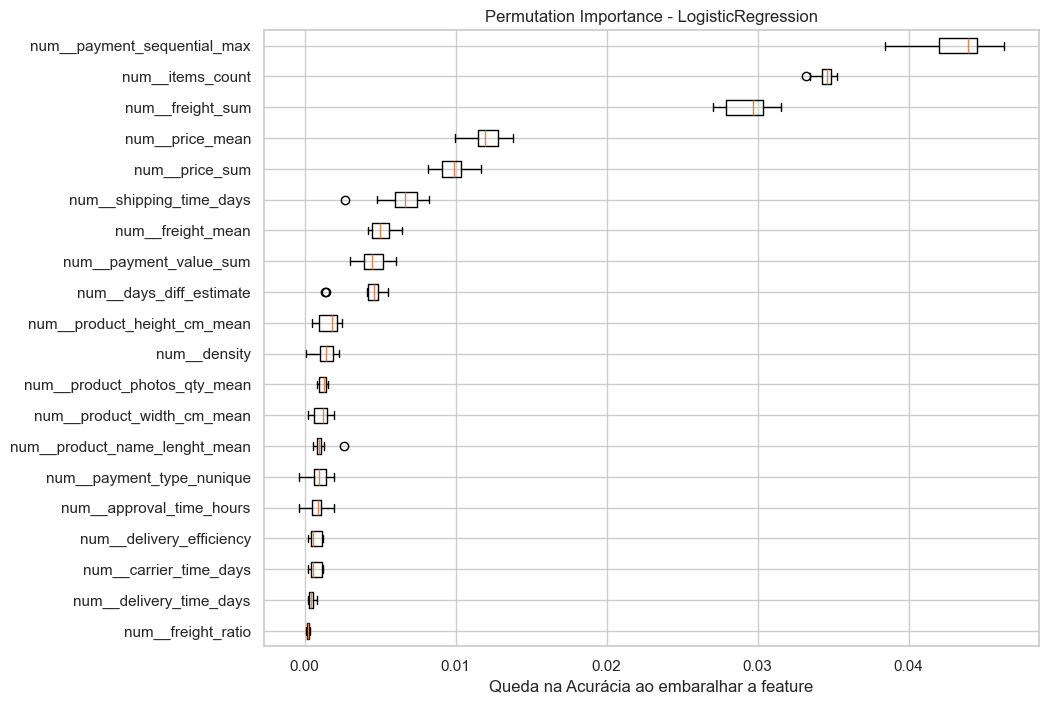

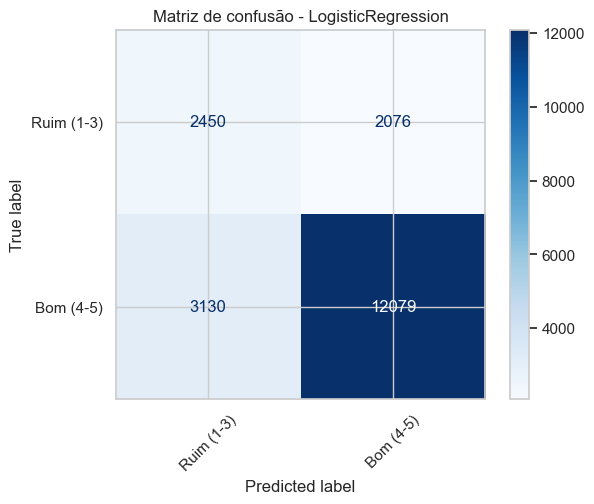


=== RandomForest ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.81      0.30      0.43      4526
   Bom (4-5)       0.82      0.98      0.89     15209

    accuracy                           0.82     19735
   macro avg       0.82      0.64      0.66     19735
weighted avg       0.82      0.82      0.79     19735



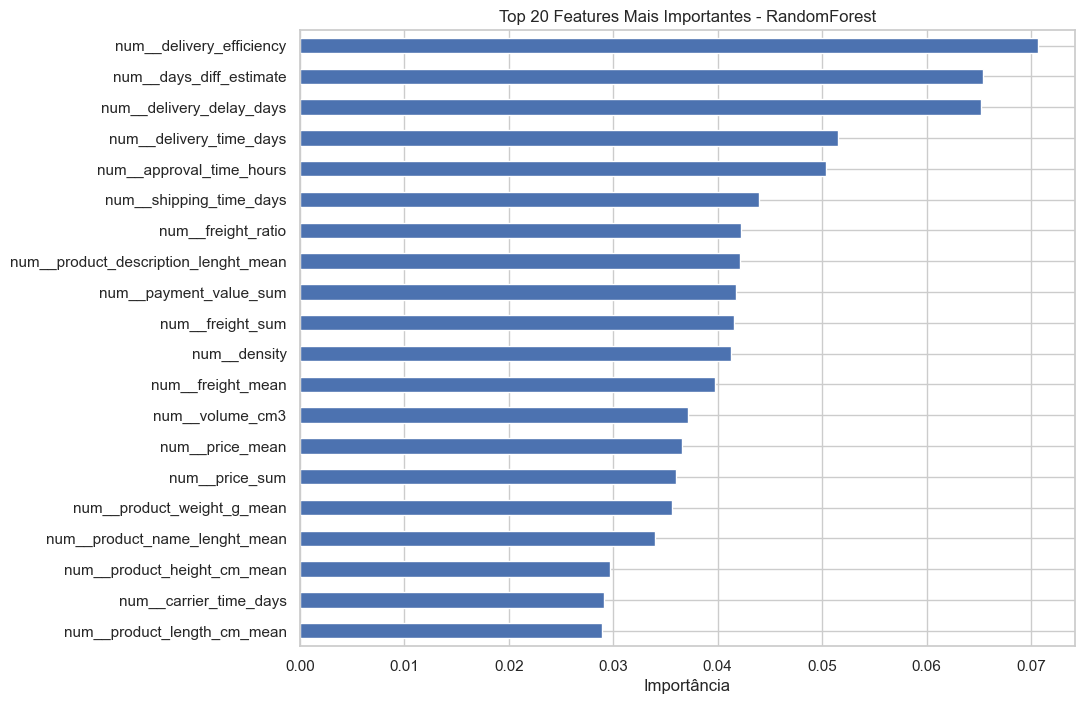

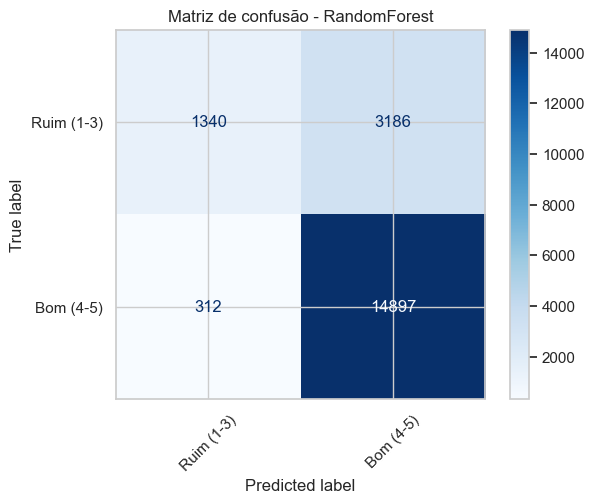


=== HistGradientBoosting ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.83      0.30      0.44      4526
   Bom (4-5)       0.82      0.98      0.90     15209

    accuracy                           0.82     19735
   macro avg       0.83      0.64      0.67     19735
weighted avg       0.83      0.82      0.79     19735

Calculando importância por permutação para HistGradientBoosting... (pode demorar um pouquinho)


C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15976\1888589696.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


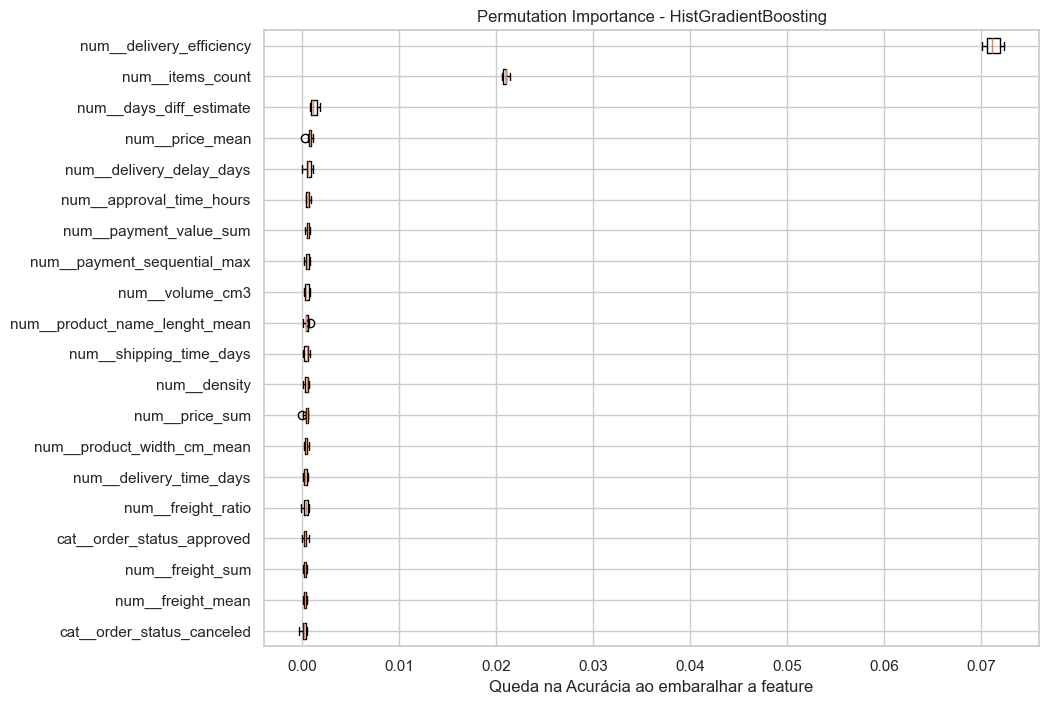

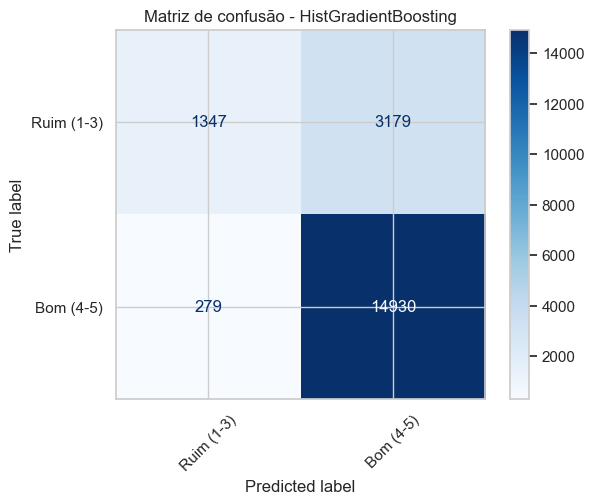


=== DecisionTree ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.48      0.52      0.50      4526
   Bom (4-5)       0.85      0.83      0.84     15209

    accuracy                           0.76     19735
   macro avg       0.67      0.67      0.67     19735
weighted avg       0.77      0.76      0.76     19735



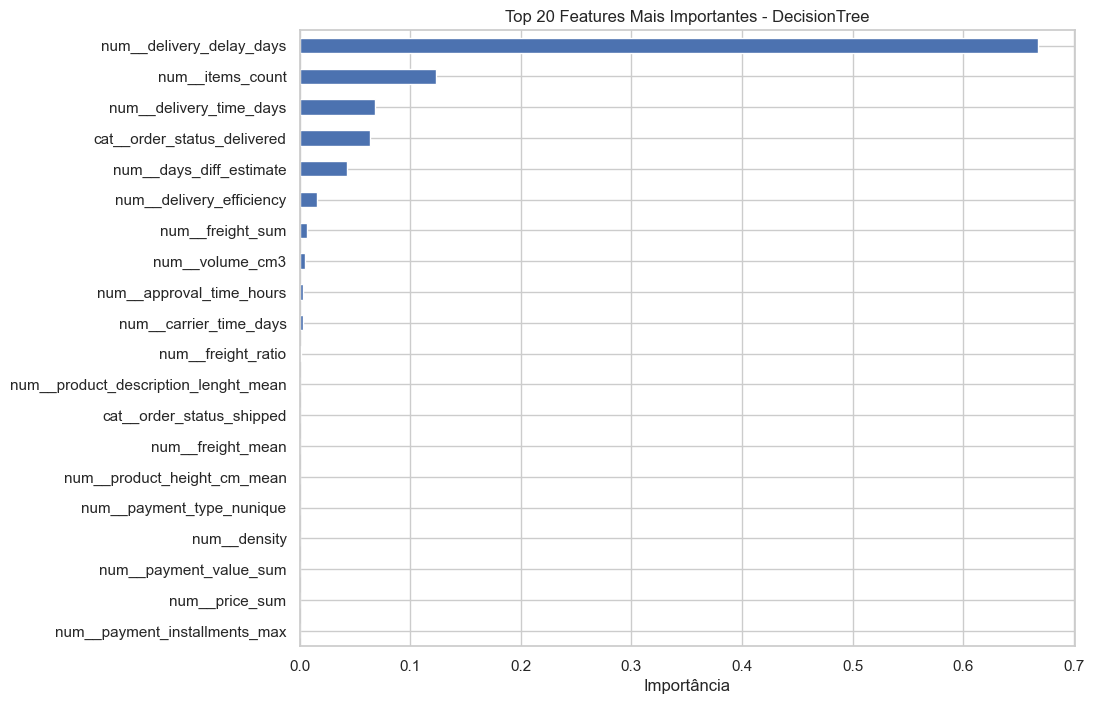

Could not plot Decision Tree map.


<Figure size 2500x1200 with 0 Axes>

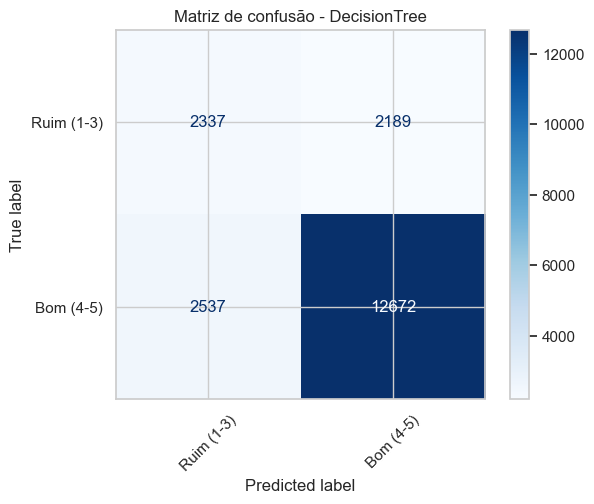


=== KNN ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.62      0.32      0.43      4526
   Bom (4-5)       0.82      0.94      0.88     15209

    accuracy                           0.80     19735
   macro avg       0.72      0.63      0.65     19735
weighted avg       0.78      0.80      0.77     19735



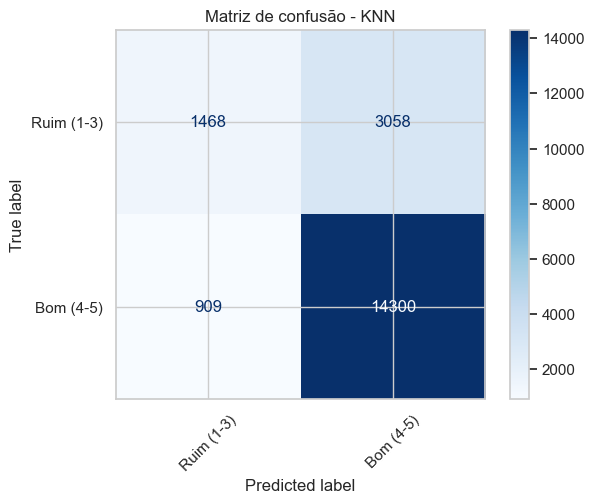


=== NeuralNetwork ===
              precision    recall  f1-score   support

  Ruim (1-3)       0.69      0.32      0.44      4526
   Bom (4-5)       0.83      0.96      0.89     15209

    accuracy                           0.81     19735
   macro avg       0.76      0.64      0.66     19735
weighted avg       0.80      0.81      0.78     19735

Calculando importância por permutação para NeuralNetwork... (pode demorar um pouquinho)


C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15976\1888589696.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


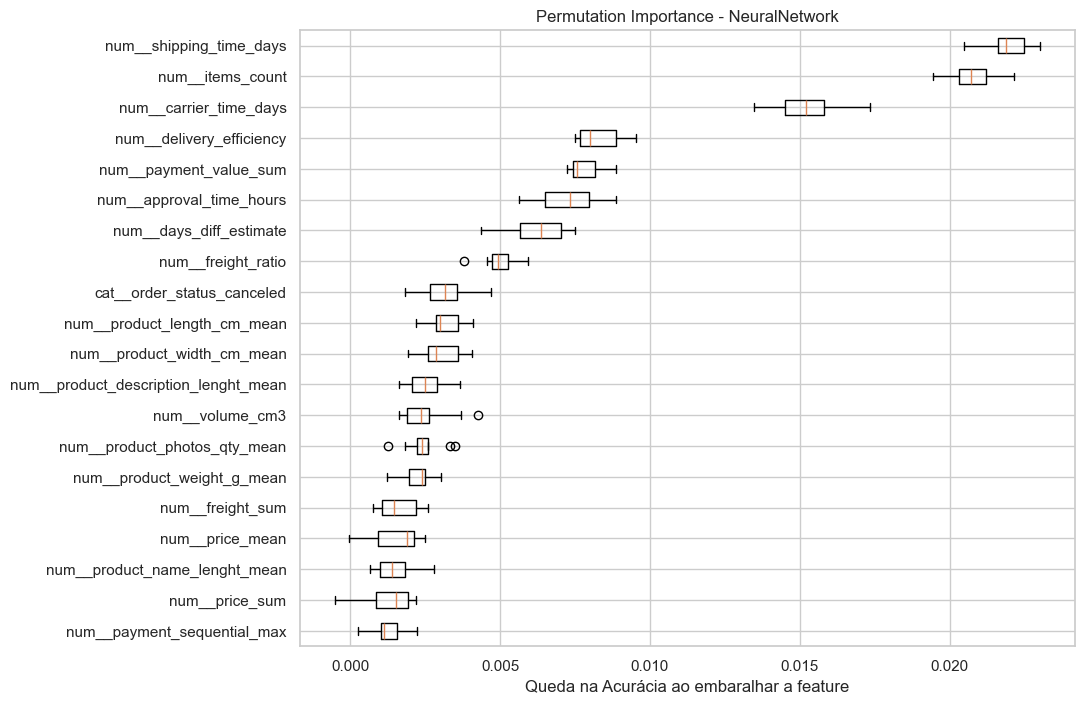

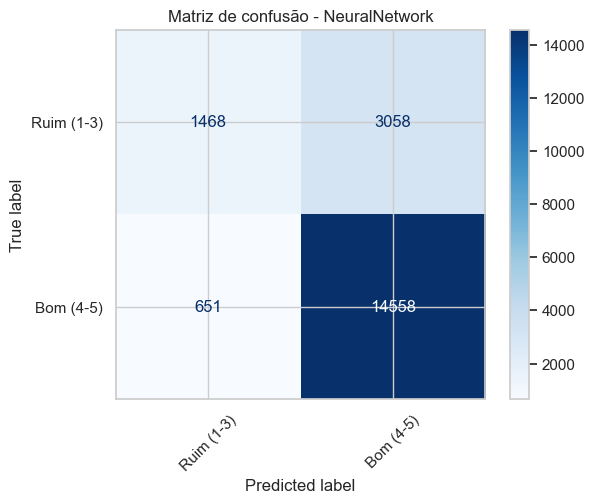

In [26]:
def classificar_binario(score):
    return 0 if score <= 3 else 1

model_data = model_data.dropna(subset=["review_score"]).copy()

X = model_data.drop(columns=["review_score"])
y = model_data["review_score"].astype(int).apply(classificar_binario)
class_names = ["Ruim (1-3)", "Bom (4-5)"]

categorical_features = ["order_status", "customer_state"]
numeric_features = [c for c in X.columns if c not in categorical_features]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000, class_weight="balanced", solver="lbfgs"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced"
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=500, random_state=42)
    
}

def plot_permutation_importance(pipeline, X_test, y_test, model_name):
    from sklearn.inspection import permutation_importance
    print(f"Calculando importância por permutação para {model_name}... (pode demorar um pouquinho)")
    
    result = permutation_importance(
        pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    sorted_idx = result.importances_mean.argsort()[-20:] # Top 20
    
    plt.figure(figsize=(10, 8))
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=feature_names[sorted_idx]
    )
    plt.title(f"Permutation Importance - {model_name}")
    plt.xlabel("Queda na Acurácia ao embaralhar a feature")
    plt.show()

def plot_feature_importance(model_name, pipeline):
    model = pipeline.named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Modelo {model_name} não suporta importância de features nativa.")
        return

    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    feat_imp.head(20).plot(kind='barh', color='#4c72b0')
    plt.title(f"Top 20 Features Mais Importantes - {model_name}")
    plt.xlabel("Importância")
    plt.gca().invert_yaxis()
    plt.show()

    if model_name in "DecisionTree":
        try:
            plt.figure(figsize=(25, 12))
            plot_tree(model.named_steps['model'], 
                    feature_names=feature_names, 
                    class_names=class_names,
                    filled=True, 
                    rounded=True, 
                    fontsize=10,
                    max_depth=3)
            plt.title("Regras de Decisão do Modelo (Decision Tree)")
            plt.show()
        except Exception as e:
            print("Could not plot Decision Tree map.")
            pass

def evaluate_model(name, model):
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=class_names))

    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(name, clf)
    else:
        if name not in "KNN":
            plot_permutation_importance(clf, X_test, y_test, name)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Matriz de confusão - {name}")
    plt.show()

for name, model in models.items():
    evaluate_model(name, model)


O algoritmo Random Forest apresentou o melhor desempenho geral, alcançando uma Acurácia de 82%. No entanto, em datasets desbalanceados como o da Olist (onde a maioria dos clientes está satisfeita), a acurácia isolada pode ser enganosa. A análise detalhada das métricas revela o real valor do modelo para o negócio:

* Alta Confiabilidade na Detecção de Risco (Precisão de 81%): O modelo demonstrou uma excelente precisão para a classe 'Ruim'. Isso significa que, quando o algoritmo sinaliza que um pedido tem risco de insatisfação, ele está correto em 81% das vezes. Para a Olist, isso permite criar um sistema de alerta com pouquíssimos alarmes falsos, otimizando o tempo da equipe de suporte.
* Conservadorismo do Modelo (Recall de 30%): O modelo optou por uma abordagem conservadora, identificando apenas 30% do total de problemas reais.

## Regras de Associação (Market Basket Analysis)

**Objetivo**: Descobrir quais produtos são comprados juntos.

**Motivação**: Cross-selling.

### Algoritmo Apriori
É uma técnica de aprendizado de máquina não supervisionada utilizada para mineração de **regras de associação** em grandes conjuntos de dados transacionais, identificando conjuntos de itens frequentes (itemsets) e criando regras ("se A, então B") com base em métricas de suporte e confiança para encontrar padrões de compra.

* **Suporte (Support):** Mede a frequência de um conjunto de itens. É o número de transações contendo o itemset dividido pelo total de transações.
* **Confiança (Confidence)**: Mede a confiabilidade da regra. É a proporção de transações com o itemset completo em relação às que contêm apenas o antecedente (se A, então B).
* **Lift**: Indica a força da regra em comparação à aleatoriedade. Um lift > 1 sugere uma associação positiva, enquanto lift < 1 sugere associação negativa.

In [11]:
df_assoc = items.merge(orders[['order_id', 'customer_id']], on='order_id')
df_assoc = df_assoc.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')
df_assoc = df_assoc.merge(products[['product_id', 'product_category_name']], on='product_id')

df_assoc = df_assoc[['customer_unique_id', 'product_category_name']].dropna()

basket = (df_assoc.groupby(['customer_unique_id', 'product_category_name'])['product_category_name']
          .count().unstack().reset_index().fillna(0)
          .set_index('customer_unique_id'))


def encode_units(x):
    return True if x >= 1 else False

basket_sets = basket.map(encode_units)

basket_sets = basket_sets[(basket_sets.sum(axis=1) >= 2)]

print(f"Analisando {len(basket_sets)} transações...")

frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)

if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])
    
    print("\nTop Regras de Associação:")
    display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
else:
    print("Nenhuma regra forte encontrada. Tente baixar ainda mais o min_support.")

Analisando 2212 transações...

Top Regras de Associação:


,antecedents,consequents,support,confidence,lift
14,frozenset({casa_conforto}),frozenset({cama_mesa_banho}),0.024412,0.739726,3.035759
15,frozenset({cama_mesa_banho}),frozenset({casa_conforto}),0.024412,0.100186,3.035759
21,frozenset({construcao_ferramentas_iluminacao}),frozenset({moveis_decoracao}),0.008137,0.600000,2.577087
20,frozenset({moveis_decoracao}),frozenset({construcao_ferramentas_iluminacao}),0.008137,0.034951,2.577087
2,frozenset({cool_stuff}),frozenset({bebes}),0.014014,0.196203,2.508671
3,frozenset({bebes}),frozenset({cool_stuff}),0.014014,0.179191,2.508671
0,frozenset({brinquedos}),frozenset({bebes}),0.012206,0.156069,1.995523
1,frozenset({bebes}),frozenset({brinquedos}),0.012206,0.156069,1.995523
22,frozenset({telefonia}),frozenset({informatica_acessorios}),0.009042,0.160000,1.734902
23,frozenset({informatica_acessorios}),frozenset({telefonia}),0.009042,0.098039,1.734902


### Regras Encontradas

* Regra: `frozenset({casa_conforto})` ➔ `frozenset({cama_mesa_banho})`
    - Se um cliente compra algo de Casa Conforto (como uma almofada ou um puff), existe 74% de probabilidade (Confiança de 0.739) de ele também levar algo de "Cama, Mesa e Banho" (como um lençol ou toalha).

* Regra `frozenset({construcao_ferramentas_iluminacao})` ➔ `frozenset({moveis_decoracao})`
    - Quem compra itens de iluminação (lustres, lâmpadas led), 60% também leva Móveis ou Decoração: cliente em um Momento de Compra (reforma?)

* Regra `frozenset({telefonia})` ➔ `frozenset({informatica_acessorios})`
    - Lift acima de 1, pode indicar que um cliente ao comprar um celular, pode levar junto um cabo, carregador ou acessório de PC.

* Bebês, Brinquedos e Cool Stuff
    - Muitas regras que cruzem esses três itens, com lift alto (entre 1.99 e 2.50).



## Agrupamento (Clustering)

**Objetivo**: Criar Perfis de Vendedores ou Perfis de Logística

**Metodologia**: K-Means + Elbow Method

**Features escolhidas**: dias para entrega (`delivery_time_days`), razão do frete (`freight_ratio`), preço total (`price_sum`).

### Algoritmo K-Means
O **agrupamento k-means** é um algoritmo de aprendizado não supervisionado utilizado para agrupamento de dados, que agrupa pontos de dados não rotulados em *k* grupos ou clusters, minimizando a variância dentro de cada grupo. Ele funciona definindo centroides iniciais, atribuindo pontos à média mais próxima e recalculando os centros até a convergência. Usando o **método do cotovelo**, encontramos **4** como o número de clusters para o conjunto de dados.



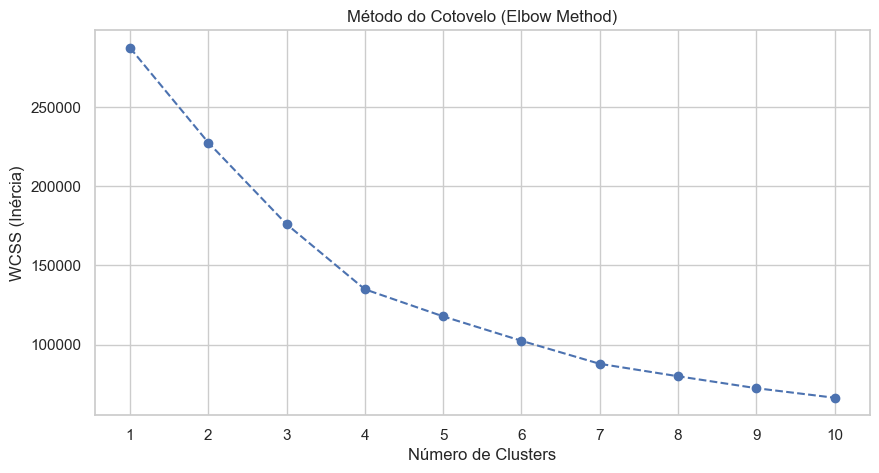

In [ ]:

# Selecting features for the clustering
cluster_cols = ['delivery_time_days', 'freight_ratio', 
                'price_sum']

# Removing nulls and negative values
df_cluster = data[cluster_cols].dropna()
# Filtering date errors
df_cluster = df_cluster[df_cluster['delivery_time_days'] > 0]

# Standardize the data
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster)

wcss = []
n_clusters_list = range(1, 11)

for i in n_clusters_list:
    kmeans_test = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_cluster)
    wcss.append(kmeans_test.inertia_)

# Plot
plt.figure(figsize=(10,5))
plt.plot(n_clusters_list, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Inércia)')
plt.xticks(n_clusters_list)
plt.grid(True)
plt.show()


### Clusters Encontrados

* **Cluster 0**: "Zona de Perigo Logístico"
    - **Características**: Demora quase um mês para chegar (28 dias). O frete é "ok" (27%), o preço é médio.
    - **Resultado**: Nota 3.28 (A pior de todas)
    - **Insight**: Esse é o grupo que queima o filme da Olist. Clientes aqui estão furiosos com a demora
* **Cluster 1**: "Experiência Ideal"
    - **Características**: Entrega "Jato" (8 dias). Preço acessível.
    - **Resultado**: Nota 4.32 (A melhor)
    - **Insight**: Velocidade é o maior driver de satisfação nesse e-commerce
* **Cluster 2**: "Ticket Alto / Frete Diluído
    - **Características**: Produtos caros (Média R$ 1.000,00). O frete representa muito pouco do valor (6%). Entrega média (12 dias)
    - **Resultado**: Nota 4.09 (Boa)
    - **Insight**: Quem compra coisas caras (ex: Eletrônicos, Geladeiras) tolera esperar 12 dias e não se importa com o frete, pois ele é irrisório perto do valor do produto
* **Cluster 3**: "Produtos Baratos / Frete Caro"
    - **Características**: Produto muito barato (R$ 29,00), mas o frete é quase o mesmo valor do produto (Ratio 0.94 ou 94%)
    - **Resultado**: Nota 4.19 (Surpreendentemente alta)
    - **Insight**: Por que a nota é boa? Provavelmente o cliente sabe que está comprando uma "bugiganga" barata e aceita pagar o frete porque ainda vale a pena ou não tem pressa. A expectativa é alinhada



=== Perfil dos Clusters (Médias) ===
         delivery_time_days  freight_ratio    price_sum
cluster                                                
0                 28.338316       0.275238   134.883863
1                  8.727697       0.229483   116.903946
2                 12.839243       0.064585  1001.155129
3                 12.380525       0.944554    29.156784

=== Validação: Média de Nota por Cluster ===
cluster
0    3.286402
2    4.092599
3    4.196005
1    4.325430
Name: review_score, dtype: float64


C:\Users\Beatriz\AppData\Local\Temp\ipykernel_15976\1930095052.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_cluster['cluster'], y=df_cluster['review_score'], palette='viridis')


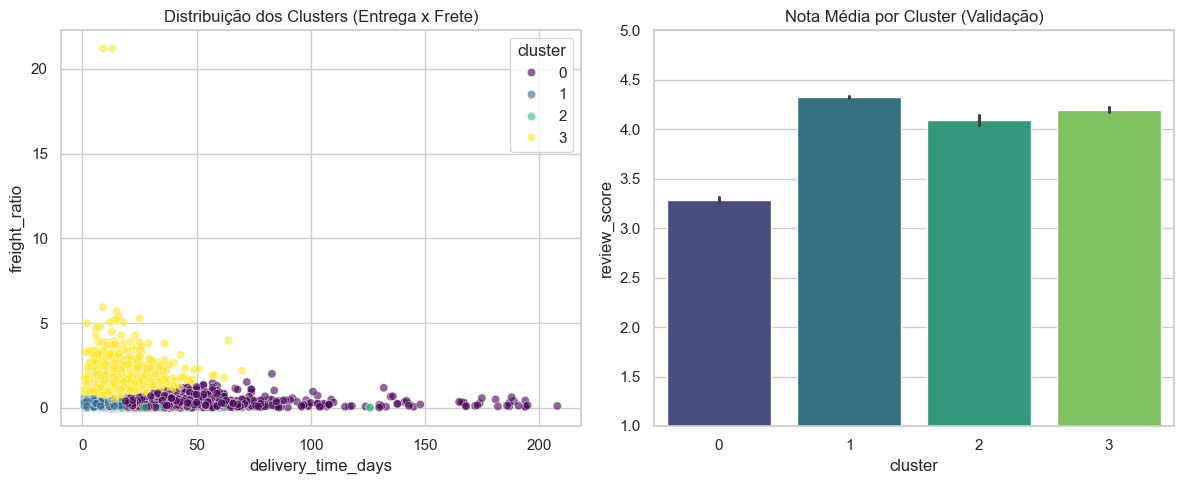

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_cluster)

# Cluster Analysis (The Key to Success)
print("=== Perfil dos Clusters (Médias) ===")
profile = df_cluster.groupby('cluster').mean()
print(profile)

# Validation: Cross-check with the Review Score
# We retrieve the score using the index
df_cluster['review_score'] = data.loc[df_cluster.index, 'review_score']

print("\n=== Validação: Média de Nota por Cluster ===")
score_profile = df_cluster.groupby('cluster')['review_score'].mean().sort_values()
print(score_profile)

plt.figure(figsize=(12, 5))

# Chart 1: Characteristics
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_cluster, x='delivery_time_days', y='freight_ratio', hue='cluster', palette='viridis', alpha=0.6)
plt.title("Distribuição dos Clusters (Entrega x Frete)")

# Chart 2: Scores
plt.subplot(1, 2, 2)
sns.barplot(x=df_cluster['cluster'], y=df_cluster['review_score'], palette='viridis')
plt.title("Nota Média por Cluster (Validação)")
plt.ylim(1, 5)

plt.tight_layout()
plt.show()

## Conclusões

- A aplicação do algoritmo não-supervisionado **K-Means** corroborou, de forma independente, a hipótese de que a logística é o fator determinante para a satisfação do cliente no e-commerce brasileiro.
- Features de **logística** (tempo/atraso de entrega) tendem a ter impacto direto na satisfação do cliente e são especialmente relevantes para o problema.
- A aplicação do **algoritmo Apriori** revelou que as cestas de compras na Olist não são puramente aleatórias. Foram identificados padrões de comportamento baseados no 'momento de vida' do consumidor. Esses resultados podem ser diretamente aplicados na criação de 'Kits de Produtos', algoritmos de recomendação no carrinho de compras e campanhas de e-mail marketing direcionadas.
